## Power Masternodes

First, load everthing at once.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

from etherscan import Etherscan

import json
import time
import os
import random
import math

import scipy.stats as st


print(pd.__version__)
print(np.__version__)
print(requests.__version__)
print(plt.matplotlib.__version__)


# https://martin-thoma.com/configuration-files-in-python/

import json

with open("../3_api/.private/keys.json") as keys_file:
    KEYS = json.load(keys_file)

# Note: don't print the key, or if you do, delete the cell's output
# (cell outputs are saved and can be sent to Github).


## DEEPDAO

def deepdao(query, params=None, post=False):

    ENDPOINT = 'https://api.deepdao.io/v0.1/'

    headers={
        'x-api-key': KEYS['DEEPDAO'],
        'accept': 'application/json'
    }

    if post:
        response = requests.post(ENDPOINT + query,
                                headers=headers,
                                json=params)
    else:
        response = requests.get(ENDPOINT + query,
                                headers=headers,
                                params=params)

    print(response)
    return response.json()

## ETHERSCAN
############

def etherscan(params={}):

    ENDPOINT = 'https://api.etherscan.io/api'

    params['apikey'] = KEYS['ETHERSCAN']

    response = requests.get(ENDPOINT,
                            headers={
                                'accept': 'application/json',
                                "User-Agent": ""
                            },
                            params=params)

    print(response)
    return response.json()


eth = Etherscan(KEYS['ETHERSCAN'])

## SNAPSHOT
###########

SNAPSHOT_ENDPOINT = "https://hub.snapshot.org/graphql"

snapshot = Client(
    transport=AIOHTTPTransport(url=SNAPSHOT_ENDPOINT)
)


def snapshot_rest(query, params=None):

    response = requests.post(SNAPSHOT_ENDPOINT,
                            headers={                      
                                'accept': 'application/json'
                            },
                            params={
                                'query': query
                            })

    print(response)
    return response.json()['data']

## THE GRAPH
############

## Endpoints depends on subgraph of interest.


def pd_read_json(file):
    ## Prevents Value too big Error.
    with open(file) as f:
        df = json.load(f)
    df = pd.DataFrame(df)
    return df


def get_query(filename, do_gql=False):
    with open("gql_queries/" + filename.replace(".gql", "") + ".gql") as f:
        query = f.read()
        if do_gql: query = gql(query)
    return query
    
## Alias gq.
gq = get_query


def get_query(filename, do_gql=False):
    with open("gql_queries/" + filename.replace(".gql", "") + ".gql") as f:
        query = f.read()
        if do_gql: query = gql(query)
    return query
    
## Alias gq.
gq = get_query

async def gql_all(query, field, first=1000, skip=None, initial_list=None, 
                  counter = True, limit=None, save=None, save_interval=10, clear_on_save = False, append=True, rest=False, data_dir="data", save_counter = 1, vars=None):

    ## The returned value and the varible used to accumulate results.
    out = []

    ## Utility function to save intermediate and final results.
    def save_json():

        # Pandas has problem load pure json saves.
        # Hence we create a pandas Dataframe and save it.
        # nonlocal append
        # flag = "a" if append else "w"
        # with open("data/" + save, flag) as f:
        #     json.dump(out, f)
        #     print("Saved.")

        nonlocal out
        df = pd.DataFrame(out)

        if clear_on_save:
            
            nonlocal save_counter
            
            sv = str(save_counter)
            sv = sv.zfill(5)
            save_counter += 1

            filename = save.replace('.json', '_' + sv + '.json')
            
            out = []
            out_str = "Saved and cleared."
        else:
            filename = save
            out_str = "Saved."
        
        df.to_json(data_dir + "/" + filename, orient="records")
        print(out_str)

        
    ## Load initial list.
    ## If no skip is provided, then skip is set to the length of
    ## the initial list, otherwise we use the user-specified value
    if initial_list:
        out = initial_list
        if skip is None:
            skip = len(out)
    elif skip is None:
        skip = 0

    ## Make a GQL query object, if necessary.
    if not rest and type(query) == str:
        query = gql(query)
        

    my_counter = 0
    fetch = True
    try:
        while fetch:
            
            my_counter += 1
            if limit and my_counter > limit:
                print('**Limit reached: ', limit)
                fetch = False
                continue

            if rest:

                # Building query manually.
                q = query.replace("($first: Int!, $skip: Int!)", "")
                q = q.replace("$first", str(first))
                q = q.replace("$skip", str(skip))
                # print(q)

                ## Optional additional variables.
                if vars:
                    for v in vars:
                        q = q.replace("$" + v, str(vars[v]))

                res = snapshot_rest(q)
                
            else:
                
                _vars = {"first": first, "skip": skip}
                
                ## Optional additional variables.
                if vars:
                    _vars = _vars | vars

                res = await snapshot.execute_async(query, variable_values=_vars)
            
            if not res[field]:
                print('**I am done fetching!**')
                fetch = False
            else:
                out.extend(res[field])
                skip += first
                if counter: print(my_counter, len(out))

                if save and my_counter % save_interval == 0:
                    save_json()

        if save and my_counter % save_interval != 0:
            save_json()

    except Exception as e:
        print(str(e))
        print("**An error occurred, exiting early.**")
        if save: save_json()
    
    return out

def pd_read_dir(dir, blacklist=None, whitelist=None, ext=('.json')):
    dir_df = pd.DataFrame()
    

    for file in os.listdir(dir):
        if blacklist and file in blacklist:
            continue
        if whitelist and file not in whitelist:
            continue

        if file.endswith(ext):
            tmp_df = pd_read_json(dir + '/' + file)
            dir_df = pd.concat([dir_df, tmp_df])
    
    return dir_df

1.3.4
1.21.2
2.26.0
3.5.0


## Preparing to compute power as in Mosley et al. (2022).

"Towards a systemic understanding of blockchain governance in proposal voting: A dash case study."

Load `spaces`, `proposals`, and `votes`.

In [11]:
spaces = pd_read_json("data/snapshot_spaces.json")

all_proposals = pd_read_json("data/5_snapshot_pancake_proposals.json")


In [14]:
## If downloaded already.
all_votes = pd_read_dir("data/votes")

In [15]:
## Otherwise.
## This query takes a while...
# votes_query = gq("snapshot_votes")
# res = await gql_all(votes_query, 
#                     field="votes", 
#                     rest=True,
#                     save="snapshot_votes_test.json",
#                     data_dir="data/votes/",
#                     save_interval = 20,
#                     limit=2,
#                     first=20000, # First can be a high number.
#                     clear_on_save=True
#                     )

In [16]:
print("spaces: ", len(spaces))
print("proposals: ", len(all_proposals))
print("votes: ", len(all_votes))

spaces:  11078
proposals:  2263
votes:  99893


### Cleanup

#### Proposals

In [17]:
all_proposals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2263 non-null   object 
 1   ipfs                2263 non-null   object 
 2   author              2263 non-null   object 
 3   created             2263 non-null   int64  
 4   space               2263 non-null   object 
 5   network             2263 non-null   object 
 6   symbol              2263 non-null   object 
 7   type                2263 non-null   object 
 8   strategies          2263 non-null   object 
 9   plugins             2263 non-null   object 
 10  title               2263 non-null   object 
 11  body                2263 non-null   object 
 12  discussion          2263 non-null   object 
 13  choices             2263 non-null   object 
 14  start               2263 non-null   int64  
 15  end                 2263 non-null   int64  
 16  quorum

In [28]:
# all_proposals['space'] = all_proposals['space'].apply(lambda x : x['id'])

In [29]:
all_proposals['space'].head() 

0    pancake
1    pancake
2    pancake
3    pancake
4    pancake
Name: space, dtype: object

#### Votes.

In [30]:
all_votes.head()


,id,ipfs,voter,created,space,proposal,choice,metadata,reason,app,vp,vp_by_strategy,vp_state,vote_distance
0,QmY3RStzfrjtnFUmZvwfriqtobDndKC2v5bY7gGt3yqmdk,QmY3RStzfrjtnFUmZvwfriqtobDndKC2v5bY7gGt3yqmdk,0xfe36132CAa71c4B1A88b38B79373aAb5E001457c,1636888820,pancake,0x8aec905ad562f5a320f7ae7d11d4d3de5eb48c70741b...,-1,{},,,0.001,[0.001],final,0.0
1,QmZh17iC3C8pUD9J9xxCKHwPdtqetbMUyDndd5JdMYkP77,QmZh17iC3C8pUD9J9xxCKHwPdtqetbMUyDndd5JdMYkP77,0xD3815588b090Cd966fA078134517eb091ea5a22c,1636888820,pancake,0x8aec905ad562f5a320f7ae7d11d4d3de5eb48c70741b...,-1,{},,,0.001,[0.001],final,0.0
2,QmbXri9w7yau8mU7J91cRgT3FLNDgaKpm7DbQhESgJnzD6,QmbXri9w7yau8mU7J91cRgT3FLNDgaKpm7DbQhESgJnzD6,0x6e02F9ebcbeA1D919E77d237cD32150d00F41B03,1636888821,pancake,0xc36810958127e4d424b287cf168e972abdc6321403ef...,-1,{},,,0.001,[0.001],final,0.0
3,Qmc885Jdk1qPQLYpWyj2dSSG1azMgCFEtYZrs68tD3uTK5,Qmc885Jdk1qPQLYpWyj2dSSG1azMgCFEtYZrs68tD3uTK5,0x0b0498E4FB7817358fee5B20501DB0cE7e40bA36,1636888821,pancake,0xff8e1a71a0675b8fd96c7828c1df1e0939ac3fc7a90a...,-1,{},,,0.001,[0.001],final,0.0
4,QmdoVaEeaEVC3hnycezMozfQ2gHWCLujcw4bXovaGgtXzz,QmdoVaEeaEVC3hnycezMozfQ2gHWCLujcw4bXovaGgtXzz,0xadEF37Aa14Ef396167982a3c547a0C796C01f28C,1636888821,pancake,0x8aec905ad562f5a320f7ae7d11d4d3de5eb48c70741b...,-1,{},,,0.001,[0.001],final,0.0


In [31]:
# all_votes['space'] = all_votes['space'].apply(lambda x : x['id'])


In [32]:
# ## Returns an error, we need to account for a None field.
# # all_votes['proposal'] = all_votes['proposal'].apply(lambda x : x['id'])

# all_votes['proposal'] = all_votes['proposal'].apply(lambda x : 
#     x if x is None else x['id']
# )

#### Pancake Swap

Who did most of the proposals?

In [33]:
most_props = spaces[spaces['proposalsCount'] == max(spaces['proposalsCount'])]
DAO_MOST_PROPS_ID = most_props['id'].iloc[0]
DAO_MOST_PROPS_ID


'pancake'

In [34]:
all_proposals['space'].value_counts()

pancake    2263
Name: space, dtype: int64

In [35]:
pancake_props = all_proposals[all_proposals['space'] == DAO_MOST_PROPS_ID ]
pancake_props.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2263 entries, 0 to 2262
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2263 non-null   object 
 1   ipfs                2263 non-null   object 
 2   author              2263 non-null   object 
 3   created             2263 non-null   int64  
 4   space               2263 non-null   object 
 5   network             2263 non-null   object 
 6   symbol              2263 non-null   object 
 7   type                2263 non-null   object 
 8   strategies          2263 non-null   object 
 9   plugins             2263 non-null   object 
 10  title               2263 non-null   object 
 11  body                2263 non-null   object 
 12  discussion          2263 non-null   object 
 13  choices             2263 non-null   object 
 14  start               2263 non-null   int64  
 15  end                 2263 non-null   int64  
 16  quorum

In [36]:
pancake_votes = all_votes[all_votes['space'] == DAO_MOST_PROPS_ID ]
pancake_votes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99893 entries, 0 to 99892
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              99893 non-null  object 
 1   ipfs            99893 non-null  object 
 2   voter           99893 non-null  object 
 3   created         99893 non-null  int64  
 4   space           99893 non-null  object 
 5   proposal        99893 non-null  object 
 6   choice          99893 non-null  int64  
 7   metadata        99893 non-null  object 
 8   reason          99893 non-null  object 
 9   app             99893 non-null  object 
 10  vp              99893 non-null  float64
 11  vp_by_strategy  99893 non-null  object 
 12  vp_state        99893 non-null  object 
 13  vote_distance   99893 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 11.4+ MB


In [37]:
## Generate an error, there are mixed types.
pancake_votes['choice'].value_counts()

-1    97867
 0     1707
 1      319
Name: choice, dtype: int64

In [38]:
pancake_votes['choice'].describe()

count    99893.000000
mean        -0.976525
std          0.171205
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max          1.000000
Name: choice, dtype: float64

Let's remove non 'int' votes (e.g., ranked choices).

In the real analysis we should try to analyze all data.

In [39]:
print(len(pancake_votes))
pancake_votes = pancake_votes[pancake_votes['choice'].isin([1,2,3])]
print(len(pancake_votes))

99893
319


In [40]:
pancake_votes['choice'].value_counts()

1    319
Name: choice, dtype: int64

Let's center them around zero.

In [41]:
pancake_votes['choice'] = pancake_votes['choice'] - 2
pancake_votes['choice'].value_counts()

-1    319
Name: choice, dtype: int64

How much a node deviate from the others in every proposal.

In [42]:
def euclid(row):
    vote = row['choice']
    proposal = row['proposal']
    other_votes = pancake_votes[pancake_votes['proposal'] == proposal]
    distances = other_votes['choice'].apply(lambda x: math.pow((vote - x), 2))
    return math.sqrt(sum(distances))


pancake_votes['vote_distance'] = pancake_votes.apply(euclid, axis=1)

In [43]:
pancake_votes['vote_distance'].describe()


count    319.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: vote_distance, dtype: float64

<AxesSubplot:ylabel='Frequency'>

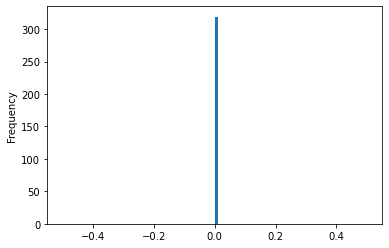

In [44]:
pancake_votes['vote_distance'].plot.hist(bins=100)

In [45]:
pancake_prop_groups = pancake_votes.groupby('proposal')


What are the proposals with the highest variation in voting?

In [46]:
pancake_prop_groups['vote_distance'].describe().sort_values('mean', ascending= False)

,count,mean,std,min,25%,50%,75%,max
proposal,,,,,,,,
0x0630836254670530442283c2758cf7a26b4caf9217f43d9c54f2045529a64a5f,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x0812f61882d4fda0967735494f8236b77f47f6806ae8a256a79e05de1bb9d44c,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
0xb86a53ae8d7e95cbfaace30dd64142cdf5d56148d462bbc6329b6ce869e84008,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
0xb77624cc6aec0fbf99a8284ac03f2b3b7fbd4754211b9e8574b1b3f38775f6e8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xb1d9feef641ded3abccfde08a46edf2f12b6eeb72e47ad94e16674a6d5bb281f,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
0x3b58cc7f37ed2777a6903ade4ed4b18d7cd75507bd20997ceee90b090d87900a,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x39386ff9c28b639397ae2b107e28820eb3b9d5c1df7bf4e49c594e7ef2afa139,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x377da27f5e4a91113207b5291aec769c4e73adfe2c546d5b568042e1ee4b51f1,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


**Exercise: implement the Masternode Voting Network algorithm**

In [47]:
voters = pancake_votes['voter'].unique()
len(voters)

232

In [48]:
## Your code here.
